# Astrostats Week 12: Other Methods
Nonnegative matrix factorization and independent component analysis are two other dimensionality reduction approaches that can sometimes do a better job at picking out interesting underlying patterns than PCA. Both of these methods rely on some fundamental assumptions about the domain and source of the data.

## Exercise: Compare "important components" found by NMF and PCA
Due to different constraints on the results, NMF and PCA will return different solutions to a similar matrix factorization problem. Sometimes, NMF can return components with more interesting features patterns than PCA. 

#### Step 1: Read in and become familar with the data

In [1]:
from sklearn.decomposition import PCA, FastICA, NMF 
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce

# Convenient plotting function
def plot_gallery(title, images, n_col=3, n_row=3, cmap='viridis'):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(int(np.sqrt(vec.size)), int(np.sqrt(vec.size))),
            cmap=cmap,
            interpolation="nearest",
            vmin=np.min(images),
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

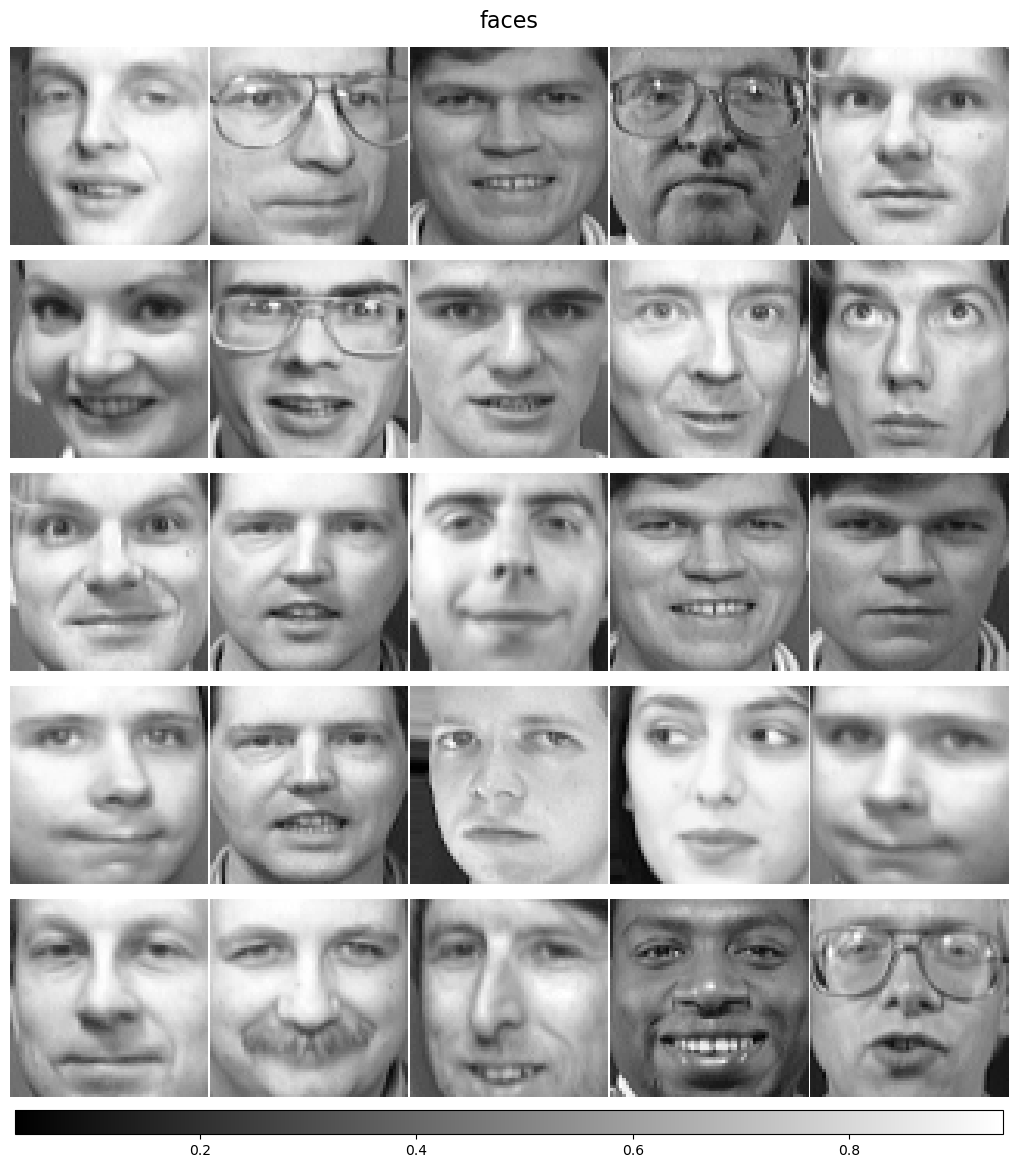

In [2]:
# get faces dataset
faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=1)
plot_gallery('faces', faces[:25], n_col=5, n_row=5, cmap='gray')

**Downsample the data**  
Downsampling faces makes Component patterns easier to see

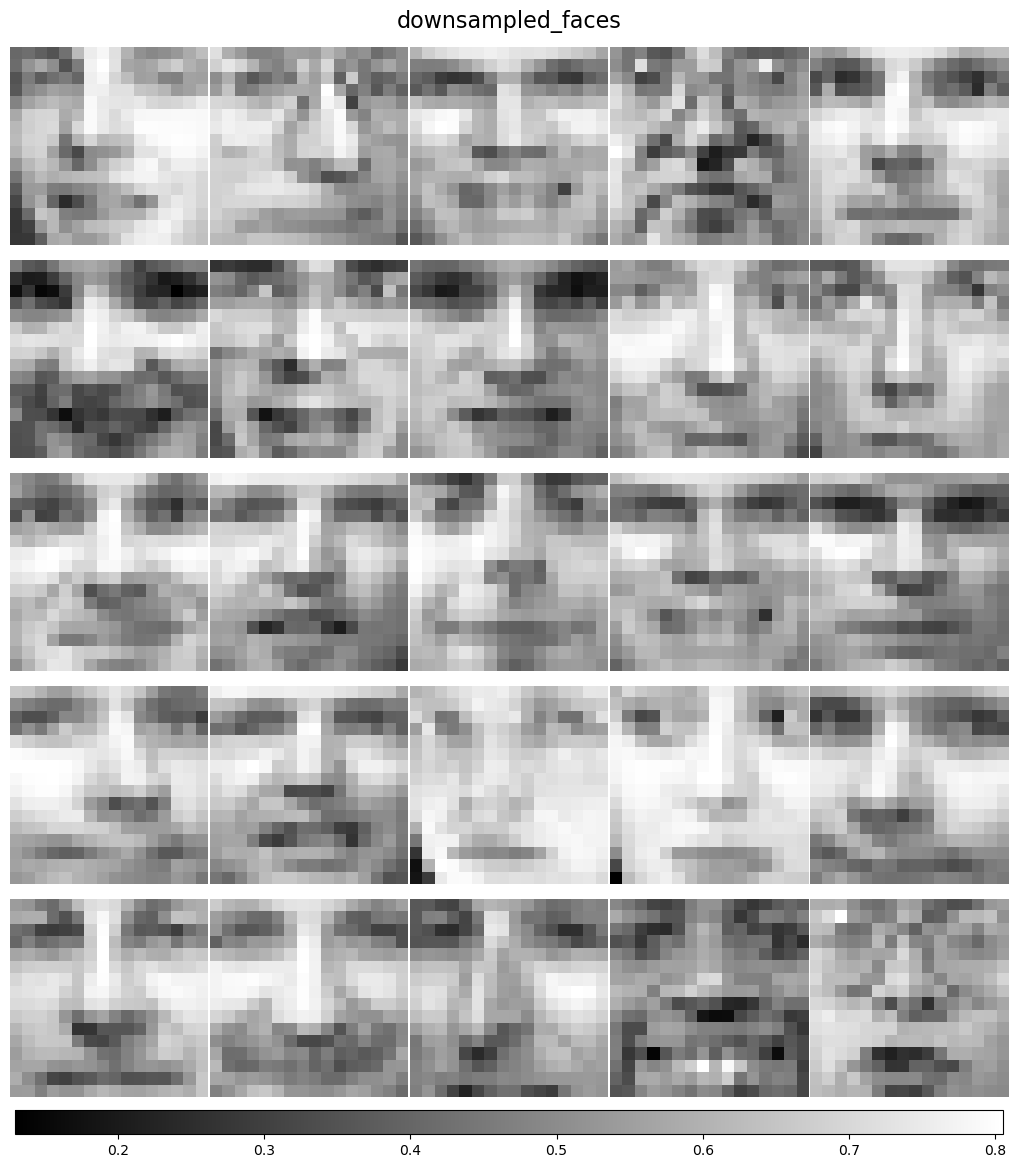

In [3]:
blocksize = 3

sqfaces = np.reshape(faces, (len(faces), 64, 64))
tmp = np.zeros((len(faces), 48, 48))
data = np.zeros((len(faces), 16,16))
for i in range(len(faces)):
    tmp[i] = sqfaces[i, 8:-8, 8:-8]
    data[i] = block_reduce(tmp[i], block_size=blocksize, func=np.mean)

faces_data = np.reshape(data, (len(faces), 16*16))

plot_gallery('downsampled_faces', data[:25], n_col=5, n_row=5, cmap='gray')

#### Step 2: Use PCA to determine the best number of components to use in your NMF fit.

We've used the [sklearn PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)  function to perform PCA on the downsampled `faces_data`.  
Determine the set of principal components which contain most of the information (the important components).

<details>
  <summary>Hint 1:</summary>
    Try plotting the the variance and cumulative sum of PCA component variances.   
    `pca.explained_variance_ratio_` gives the ratio of the variance explained by each PC.
</details>

<details>
  <summary>Hint 2:</summary>
    If there aren't any obvious elbow points in the variance plots, you can choose an arbitrary percentage of explained variance (e.g. 90%).
    Try finding the number of components at which the cumulative variance becomes greater than 90%
</details>


90% variance at: [28]


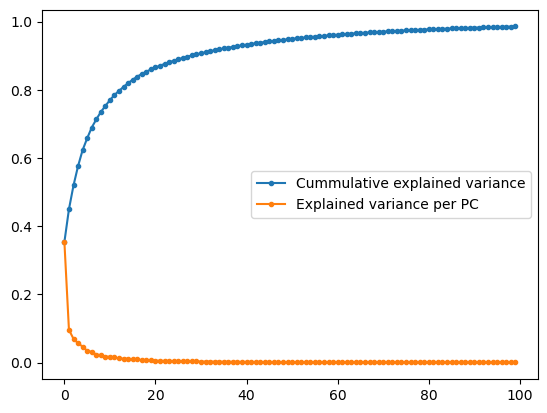

In [4]:
# ---------- 
n_pca = 100 # Your code here! what is the maximum pca dimensionality?  Hint: its related to the number of samples and the number of features

pca = PCA(n_components=n_pca )
pca.fit(faces_data)
pca_comps = pca.components_

cumulative_var = np.cumsum(pca.explained_variance_ratio_)
print('90% variance at:', np.argwhere(cumulative_var > 0.9)[0])

plt.figure()
plt.plot(cumulative_var, '.-', label='Cummulative explained variance')
plt.plot(pca.explained_variance_ratio_, '.-', label='Explained variance per PC')
plt.legend()
plt.show()

#### Step 3: Fit the `faces_data` samples with NMF!

Try the [sklearn NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF)  function to perform NMF on the downsampled `faces_data`.   


<details>
  <summary>Hint</summary>
   The syntax is very similar to the PCA syntax.
</details>

Compare the important components by plotting them with `plot_gallery`.  How do the important PCA components compare to the important NMF components?


**Play Around**  
Try tuning the number of NMF components to fit. PCA calculates all the orthogonal principle components (limited by the SVD parameters), but NMF results can vary depending on the number of components set.
  

In [6]:
n_nmf = 25 # your code here! Hint: use the number of components you found above

nmf = NMF(n_components=n_nmf, max_iter=1000)
nmf.fit(faces_data)
proj = nmf.transform(faces_data)
nmf_comps = nmf.components_

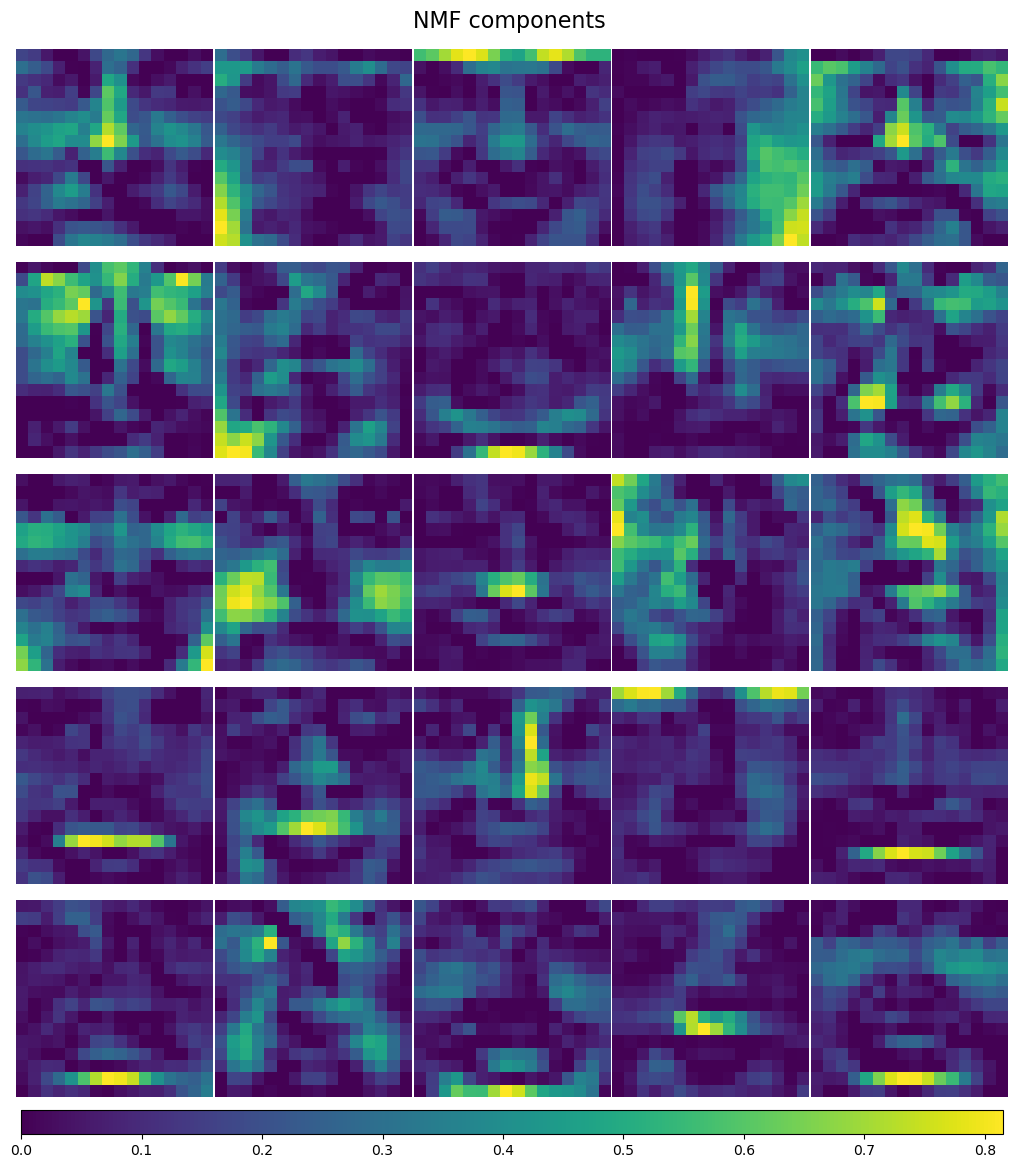

In [7]:
plot_gallery('NMF components', nmf_comps, n_col=5, n_row=5, cmap='viridis')

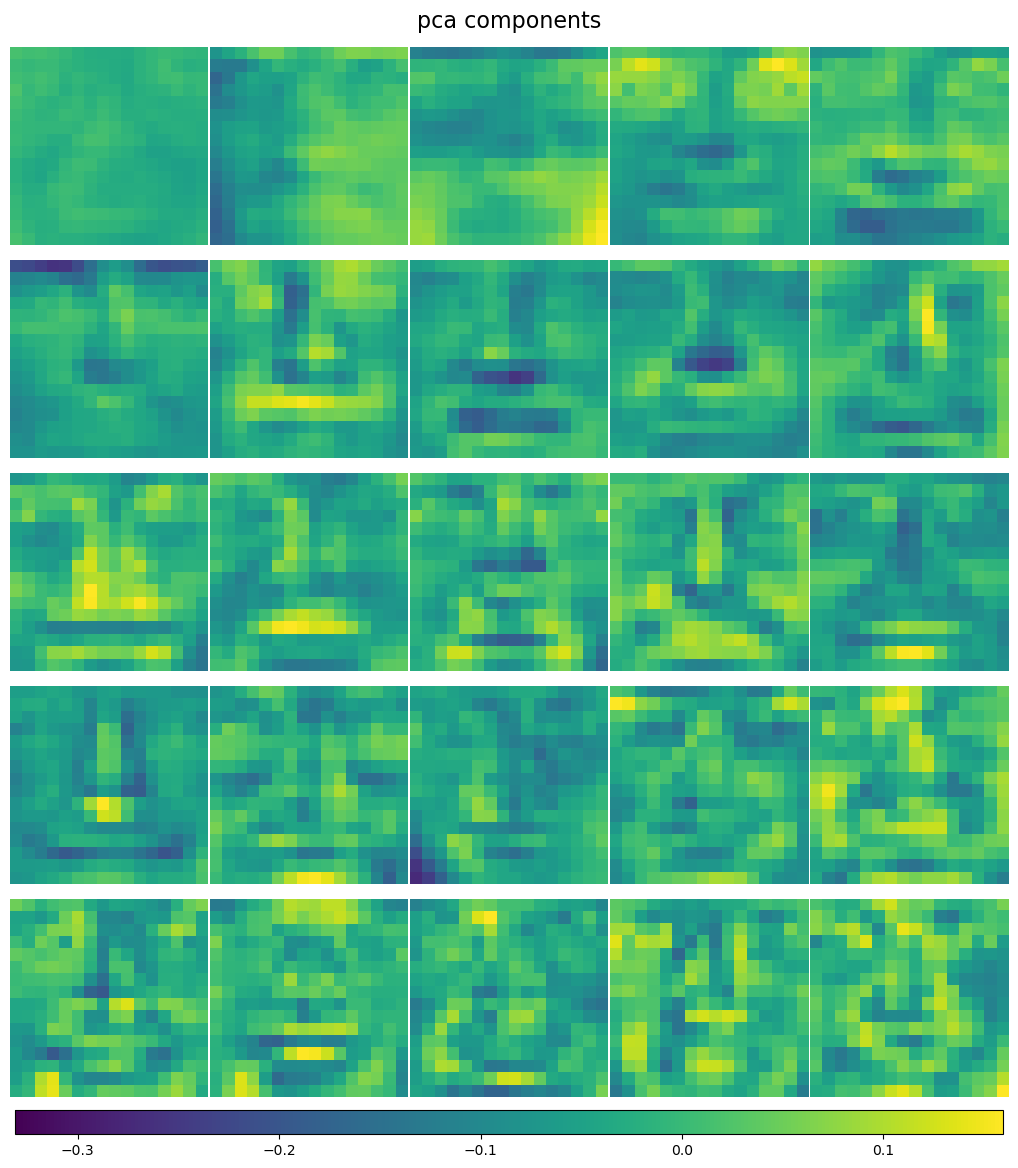

In [8]:
plot_gallery('pca components', pca_comps, n_row=5, n_col=5, cmap='viridis')


**Play Around**

Try changing the downsampling (or completely removing it) on the Olivetti faces dataset. The NMF components might not pick out the same facial features as components!

You can change the `blocksize` parameter above, or apply dimensionality reduction directly to the `faces` array

In [11]:
data = faces
nmf = NMF(n_components=25, max_iter=1000)
nmf.fit(data)
proj = nmf.transform(data)
comp = nmf.components_

pca = PCA(n_components=200)
pca.fit(data)
pcacomp = pca.components_
print(pcacomp.shape)

c:\Users\teole\anaconda3\envs\coursework\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


(200, 4096)


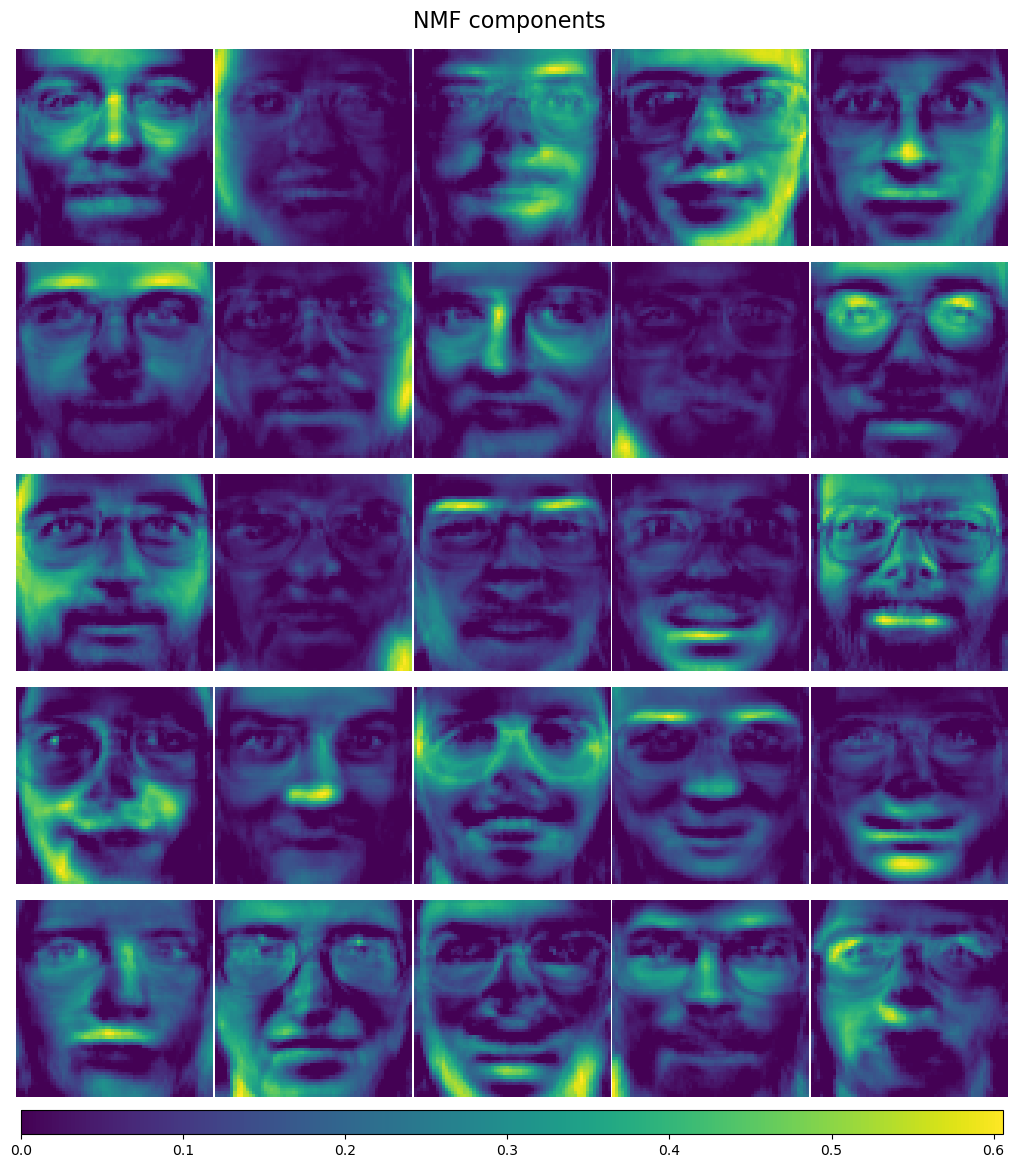

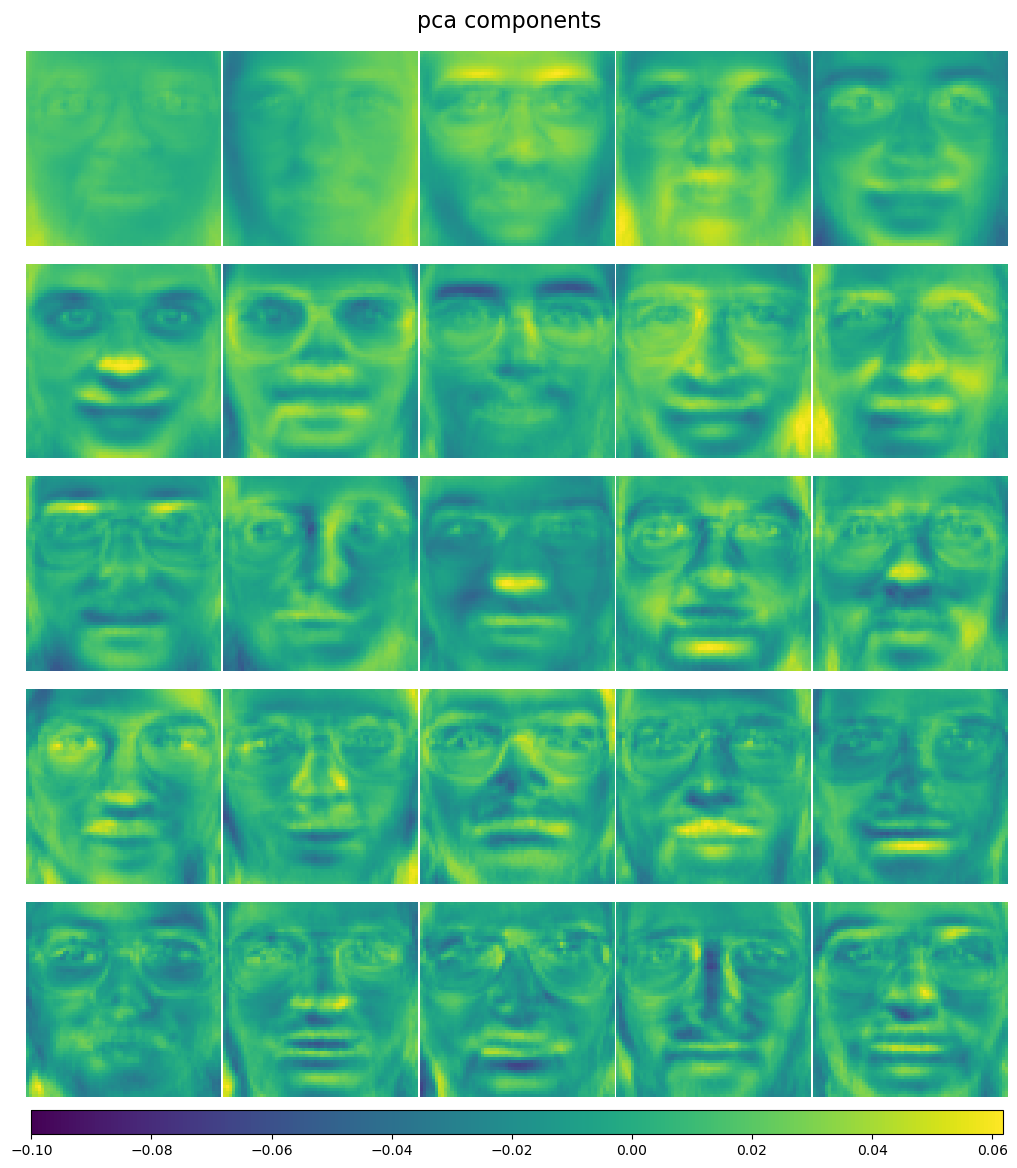

In [12]:
plot_gallery('NMF components', comp, n_col=5, n_row=5, cmap='viridis')

plot_gallery('pca components', pcacomp, n_row=5, n_col=5, cmap='viridis')


 ---
### Exercise 2: Unmixing linear combinations of waveforms with ICA

Let's create some sample data from random combinations of a few different waveforms. 

Use ICA to get the source signals back out of the combined waveforms. 
How does changing the number of components of the ICA fit affect result? 


<details>
  <summary>Hint</summary>

  The `FastICA` implementation from sklearn has the same syntax as `PCA` and `NMF`.
  
</details>

Repeat the data generation, and both fitting methods a few times. Does ICA perform better on average than PCA? 

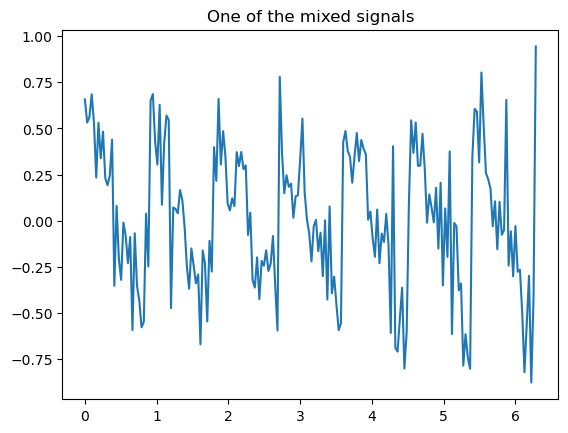

In [17]:
# Generate some source signals
from scipy.signal import sawtooth


t = np.linspace(0, 2*np.pi, 200)
# You can change waveform parameters or add new source signals too!
sine_wave = np.sin(t*15)
saw_wave = -sawtooth(t*7)
tan_wave = np.sin(np.tan(t*4)/20)
noise = np.random.normal(0, 1, (200))

# Make some linear combinations of signals
combination = np.random.uniform(0, 1, (100, 4))
functions_mat = np.stack([sine_wave, saw_wave, noise, tan_wave])
functions_mat.shape
data = (combination @ functions_mat) 
data = data - np.mean(data, axis=0) # data whitening

plt.figure()
plt.title('One of the mixed signals')
plt.plot(t, data[2])
plt.show()

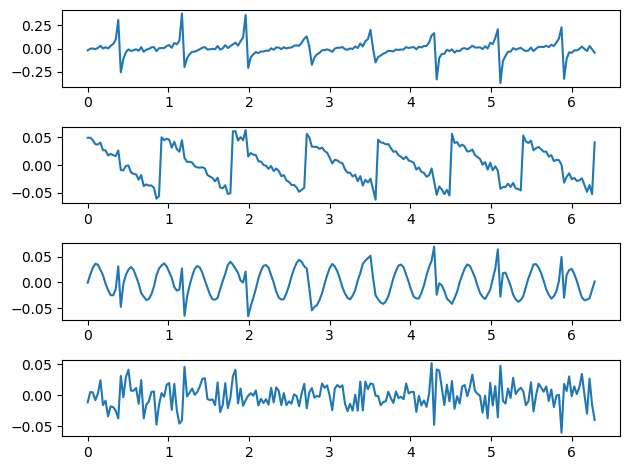

In [18]:
n_ica = 4# Your code here! how many components should you use? 
ica = FastICA(n_components=n_ica, max_iter=1000)
ica.fit(data)

comp = ica.components_
plt.subplots(4,1)
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(t, comp[i])
    plt.tight_layout()

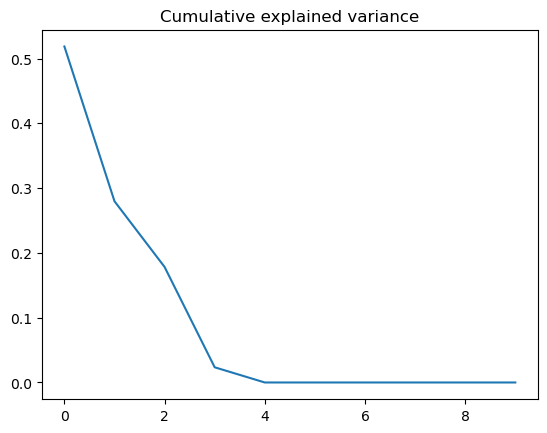

(100, 200)


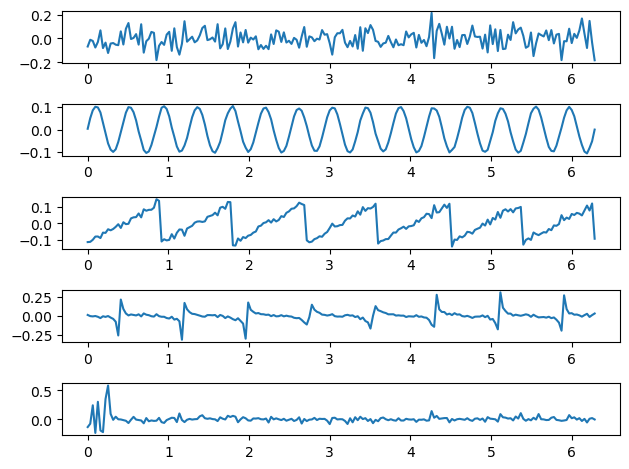

In [19]:
n_pca = 100 # Your code here! how many components should you use? 
pca = PCA(n_components= n_pca) 

pca.fit(data)
comp = pca.components_

plt.figure()
plt.title('Cumulative explained variance')
plt.plot(pca.explained_variance_ratio_[:10])
plt.show()

print(comp.shape)
plt.subplots(5,1)
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(t, comp[i])
    plt.tight_layout()


---
## Exercise 3: unmixing mistery signals
`mystery.txt` is a dataset containing 100 different combinations of a few characteristic signals. Use any method of your choice from Monday or Wednesday to find the underlying patterns in the data!

This dataset has already been standardized.

<details>
  <summary>Hint:</summary>
    Try running components through IPython.display.Audio, as in `Audio(component, rate=9600)`
</details>



#### Step 1: Load in and become familar with the data 

In [20]:
from IPython.display import Audio
dataset = np.load(r'mistery.npy')
dataset

array([[-0.03075, -0.02826, -0.101  , ...,  0.146  ,  0.1567 ,  0.0893 ],
       [-0.1445 , -0.0932 , -0.04742, ...,  0.1096 ,  0.138  ,  0.07263],
       [-0.129  , -0.08795, -0.02213, ..., -0.02719,  0.0315 ,  0.0541 ],
       ...,
       [-0.0641 , -0.1414 , -0.177  , ..., -0.1456 , -0.03122,  0.05936],
       [ 0.0561 ,  0.04474, -0.02596, ...,  0.1375 ,  0.1067 ,  0.01441],
       [-0.0654 , -0.02193,  0.07434, ..., -0.1057 , -0.1686 , -0.0741 ]],
      dtype=float16)

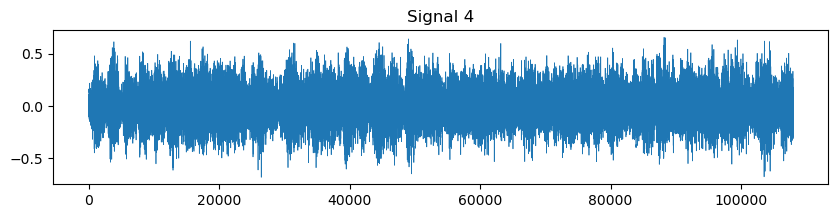

In [24]:
ind2Show = 4 # Try different signals in the dataset!

plt.figure(figsize=(10,2))
plt.title('Signal {}'.format(ind2Show))

plt.plot(dataset[ind2Show],linewidth=0.5)
Audio(dataset[ind2Show], rate=9600)

#### Step 2: Choose a dimension reduction method (PCA, NMF, or ICA), and find the most important components in the data
Plot and play these components, what do you notice? How do they compare to the original signals?

**Play Around**
Try each method and compare the results

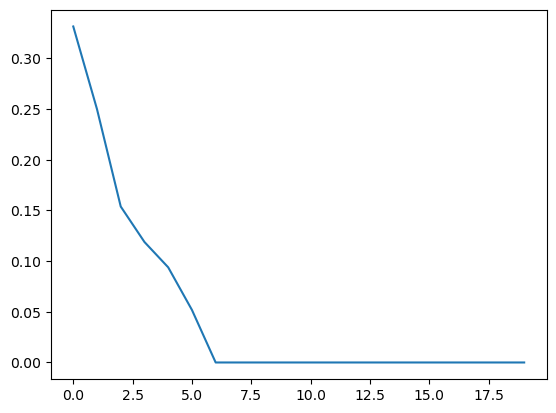

(50, 108000)


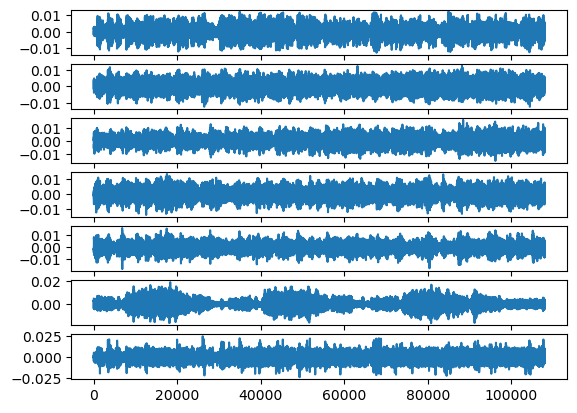

In [25]:
pca = PCA(n_components=50)
pca.fit(dataset)
pcacomp = pca.components_ 

plt.figure()
plt.plot(pca.explained_variance_ratio_[:20])
plt.show()

print(pcacomp.shape)
plt.subplots(7,1)
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(pcacomp[i])



In [ ]:
Audio(pcacomp[1], rate=9600)


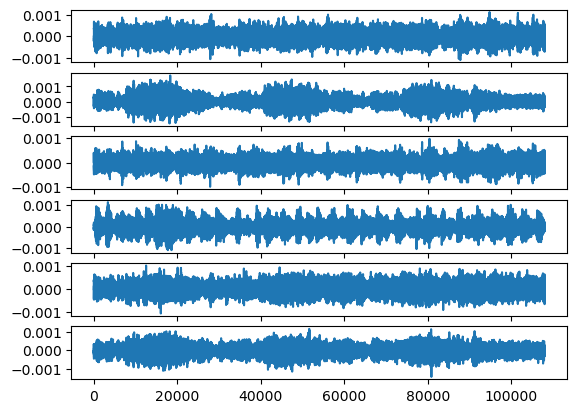

In [26]:
n= 6
ica = FastICA(n_components=n, max_iter=1000)
ica.fit(dataset)

icacomp = ica.components_#/np.max(ica.components_, axis=0)
plt.subplots(n,1)
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.plot(icacomp[i])
    # plt.tight_layout()



In [32]:
Audio(icacomp[5], rate=9600)